## 模型选择

### 训练误差和泛化误差
* 训练误差：模型在训练数据上的误差
* 泛化误差：模型在新数据上的误差
更关注泛化误差

### 验证数据集和测试数据集
* 验证数据集：一个用来评估模型好坏的数据集
    * 不要跟训练数据混在一起
* 测试数据集：只用一次的数据集
    * 测试数据集不能调参数

### K折交叉验证
* 在没有足够多数据时使用
* for in 1,...k，使用第i块作为验证数据集，其余作为训练数据集


## 过拟合和欠拟合

### 模型容量
* 拟合各种函数的能力
* 低容量的模型难以拟合训练数据
* 高容量的模型可以记住所有训练数据

### 估计模型容量
* 参数的个数
* 参数值的选择范围


## 模型选择、欠拟合和过拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


In [10]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
# 用矩阵乘法计算次方相当于每个数都经过1次方，2次方...
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [11]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]


(tensor([[0.4122],
         [1.3277]]),
 tensor([[1.0000e+00, 4.1224e-01, 8.4969e-02, 1.1676e-02, 1.2033e-03, 9.9208e-05,
          6.8162e-06, 4.0141e-07, 2.0684e-08, 9.4742e-10, 3.9056e-11, 1.4637e-12,
          5.0281e-14, 1.5944e-15, 4.6949e-17, 1.2903e-18, 3.3243e-20, 8.0612e-22,
          1.8462e-23, 4.0056e-25],
         [1.0000e+00, 1.3277e+00, 8.8136e-01, 3.9005e-01, 1.2947e-01, 3.4378e-02,
          7.6071e-03, 1.4428e-03, 2.3945e-04, 3.5324e-05, 4.6898e-06, 5.6605e-07,
          6.2628e-08, 6.3961e-09, 6.0657e-10, 5.3688e-11, 4.4550e-12, 3.4793e-13,
          2.5663e-14, 1.7933e-15]]),
 tensor([5.4079, 5.7466]))

定义一个评估函数

In [13]:
def evaluate_loss(net, data_iter, loss):
    """评估模型在给定数据集上的损失"""
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义一个训练函数

In [14]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


weight: [[ 5.0144777  1.2874918 -3.4436612  5.3489766]]


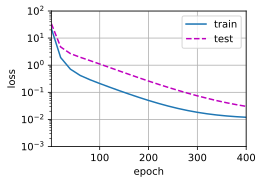

In [15]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])


weight: [[3.2559423 3.483442 ]]


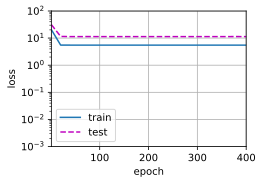

In [16]:
# 欠拟合
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])


weight: [[ 4.993211    1.2490917  -3.3127756   5.277166   -0.42450804  1.0482408
   0.04729899  0.18997562 -0.13559286 -0.09632062 -0.07643145  0.19374001
  -0.07851569  0.21074311  0.15567279  0.05265181 -0.14017326 -0.19507453
   0.21874632 -0.18459263]]


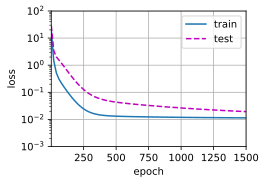

In [17]:
# 过拟合
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
